In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

In [84]:
import random
import time

In [85]:
path = "./germany_dataset/train.csv"
df = pd.read_csv(path)

In [86]:
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [87]:
df.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000


In [88]:
# All Variables declaration to use same code for different datasets
num_of_classes = df["ClassId"].nunique()
resize_x  = 15
resize_y  = 15
num_of_channels = 3
directory = "./germany_dataset/"
Epochs=250
train_length = len(df)

In [89]:
print("Total Training Examples : ",len(df))

Total Training Examples :  39209


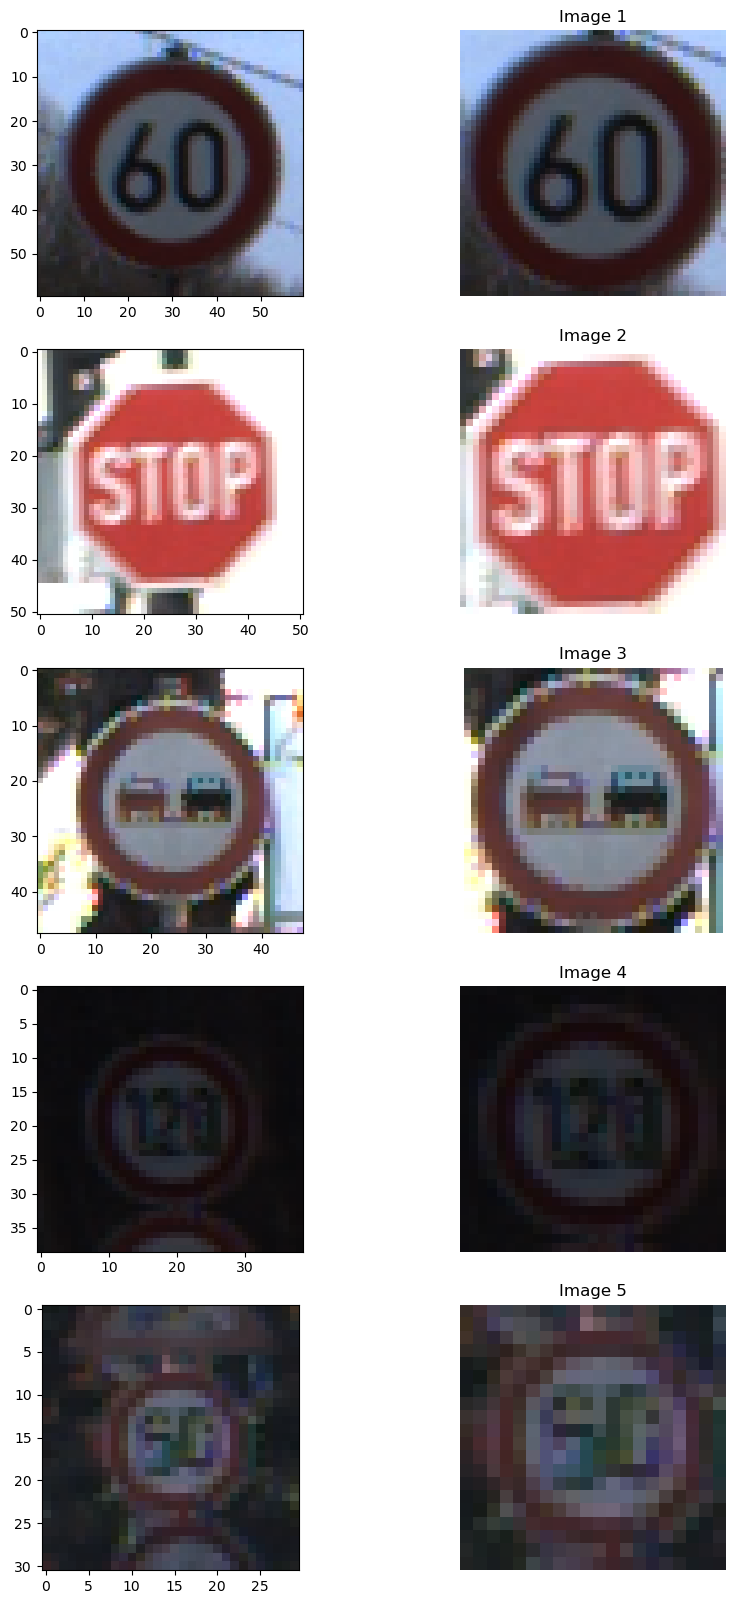

In [90]:
# Sample Images and there crop according to data given in csv
num_rows = 5
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
total_images = []
for i in range(5):
    integer = random.randint(0,train_length)
    total_images.append(df.iloc[integer].values)
total_images = list(total_images)
for i,val in enumerate(total_images):
    row = i
    col=0
    ax = axes[row, col]
    img = Image.open(directory+val[7])
    ax.imshow(img)
    img = img.crop((val[2],val[3],val[4],val[5]))
    ax = axes[row,col+1]
    ax.imshow(img)
    ax.set_title(f'Image {i + 1}')
    ax.axis('off')

Total Training Examples :  39209


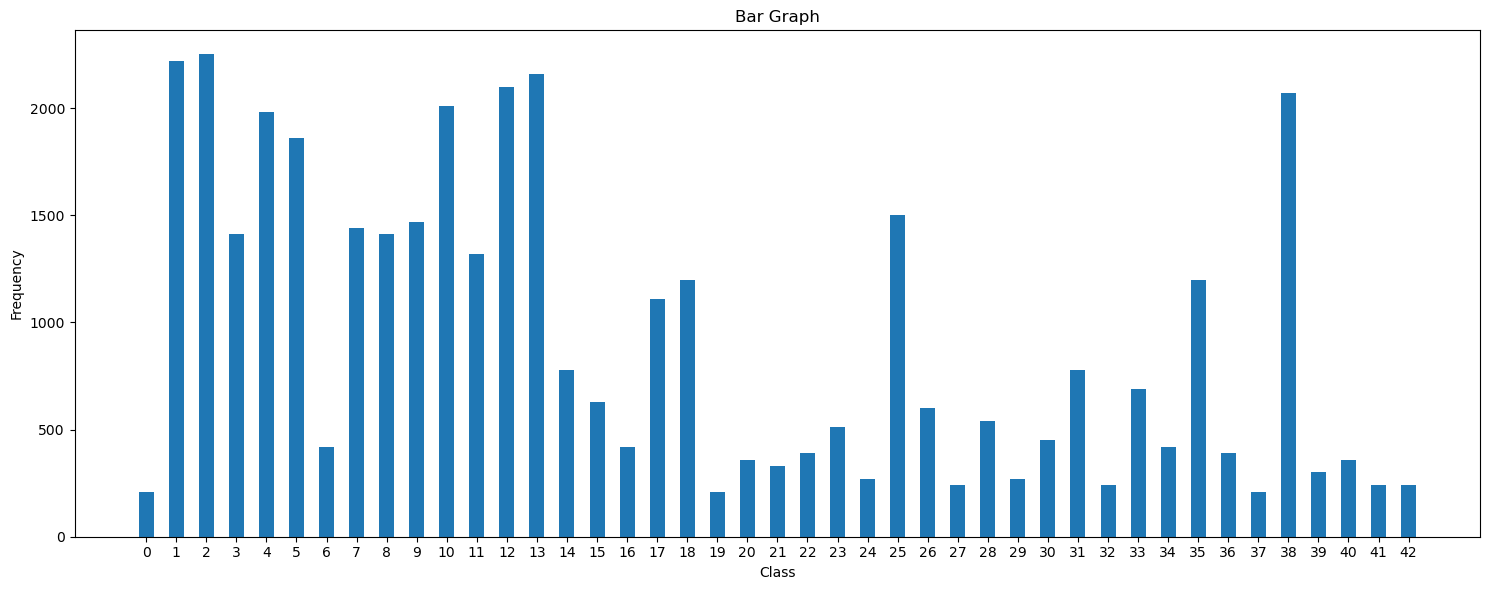

In [91]:
#Statistics of Data
print("Total Training Examples : ",len(df))
values = df["ClassId"].value_counts()
x_labels = [str(x) for x in range(num_of_classes)]
y_labels = []
for x in range(num_of_classes):
    y_labels.append(values[x])
plt.figure(figsize=(15, 6))
plt.bar(x_labels,y_labels,width=0.5)
plt.title('Bar Graph')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [92]:
# Necessary Functions

def get_max_index(arr):
    length = len(arr)
    mini = 0
    value = 0
    for i,val in enumerate(arr):
        if mini < val :
            mini = val
            value = i
    return value

def Predict_for_single_example(model,img):
    img  = np.array(img)
    img  = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    img = tf.expand_dims(img, axis=0)
    probability = model.predict(img)
    value = get_max_index(probability[0])
    return value
    
def Predict_for_Multiple_examples(model,images):
    img = np.array(images)
    img = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    probability = model.predict(img)
    values = []
    for val in probability:
        values.append(get_max_index(val))
    return values

In [93]:
class Data:
    def __init__(self,df,size_x,size_y):
        self.df = df
        self.root = directory
        self.resize_x = size_x
        self.resize_y = size_y
    
    def Do_Crop(self,path,x1,y1,x2,y2):
        img = Image.open(self.root+path)
        img = img.crop((x1,y1,x2,y2))
        return img.resize((self.resize_x,self.resize_y))
    
    def Row_Data(self,row):
        self.X.append(self.Do_Crop(row[7],row[2],row[3],row[4],row[5]))
        self.Y.append(int(row[6]))
    
    def Get_Data(self):
        self.X = []
        self.Y = []
        for index, row in df.iterrows():
            self.Row_Data(row)

In [94]:
# Reading images from local storage
starting_time = time.time()

data = Data(df,resize_x,resize_y)
data.Get_Data()

ending_time = time.time()
total_time = ending_time - starting_time
total_time/=60

print("Time taken to read images : ",total_time," min")

Time taken to read images :  0.6101129492123921  min


In [95]:
# Up-sampling the images

starting_time = time.time()
#Storing in dictionary
classes = {}

for val in range(num_of_classes):
    classes[val]=[]

max_repeating = 0;

for i,label in enumerate(data.Y):
    classes[label].append(data.X[i])

for key in classes:
    max_repeating = max(max_repeating,len(classes[key]))

for i in range(num_of_classes):
    length = len(classes[i])
    upsample_count = max_repeating - length
    for j in range(upsample_count):
        select_image = random.randint(0,length-1)
        angle = random.randint(0,359)
        classes[i].append(classes[i][select_image].rotate(angle).resize((resize_x,resize_y)))

ending_time = time.time()
total_time = ending_time - starting_time
total_time/=60

print("Time taken to upsample images : ",total_time," min")

Time taken to upsample images :  0.03276093006134033  min


(-0.5, 14.5, 14.5, -0.5)

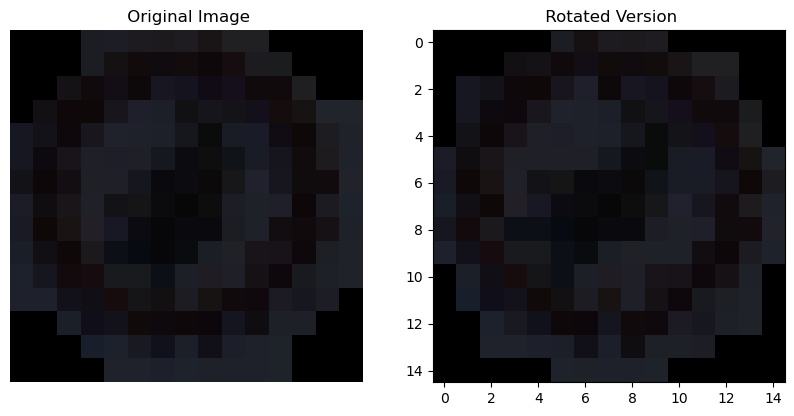

In [96]:
# Up-sampling example image

random_class = random.randint(0,num_of_classes)
length = len(classes[random_class])
random_image = random.randint(0,length-1)
img = classes[random_class][random_image]
fig, axes = plt.subplots(1, 2, figsize=(10, 20))
ax = axes[0]
axes[0].set_title(f' Original Image')
ax.imshow(img)
angle = random.randint(1,359)
img = img.rotate(angle).resize((resize_x,resize_y))
axes[1].imshow(img)
axes[1].set_title(f' Rotated Version')
ax.axis('off')

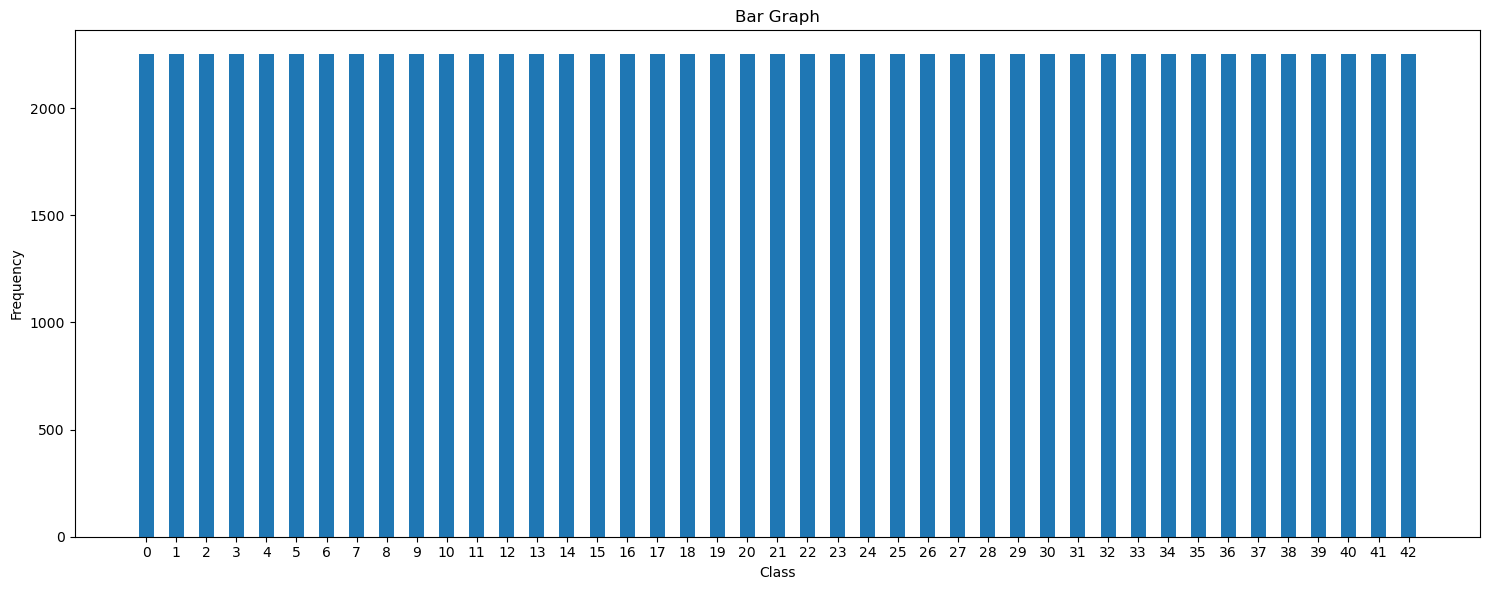

In [97]:
x_labels = [str(x) for x in range(num_of_classes)]
y_labels = []
for i in (classes):
    y_labels.append(len(classes[i]))
plt.figure(figsize=(15, 6))
plt.bar(x_labels,y_labels,width=0.5)
plt.title('Bar Graph')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [98]:
# Declaring X_train and Y_train and Re arranging the values

starting_time = time.time()

X_train = []
Y_train = []

for i in range(num_of_classes):
    for j,val in enumerate(classes[i]):
        X_train.append(np.array(val))
        Y_train.append(i)

array_pairs = list(zip(X_train, Y_train))

# Shuffle the pairs
shuffled_pairs = np.random.permutation(array_pairs)

X_train, Y_train = zip(*shuffled_pairs)

X_train = tf.convert_to_tensor(np.array(X_train),dtype=float)
Y_train = tf.convert_to_tensor(np.array(Y_train),dtype=float)


ending_time = time.time()
total_time = ending_time - starting_time
total_time/=60

print("Time taken to convert into tensor : ",total_time," min")

C:\Users\gajul\AppData\Local\Temp\ipykernel_18040\170726535.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  shuffled_pairs = np.random.permutation(array_pairs)


Time taken to convert into tensor :  0.1165856122970581  min


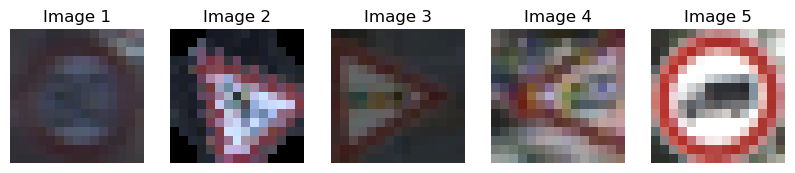

In [126]:
fig, axes = plt.subplots(1, 5, figsize=(10, 20))
length = len(X_train)
for i in range(5):
    col=i
    ax = axes[col]
    random_integer = random.randint(0,length-1)
    img = X_train[random_integer]
    ax.imshow(img)
    ax.set_title(f'Image {i + 1}')
    ax.axis('off')

In [100]:
#Data_Augmentation
X_train = X_train/255.0

In [101]:
Y_train = to_categorical(Y_train)

In [102]:
# Implementation of ANN
model = Sequential()
model.add(Flatten(input_shape=(resize_x, resize_y, num_of_channels)))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_of_classes, activation='softmax'))

In [103]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [104]:
starting_time = time.time()

history = model.fit(X_train,Y_train,epochs=Epochs,batch_size=32,validation_split=0.3)

ending_time = time.time()
total_time = ending_time - starting_time
total_time/=60

print("Time taken fit : ",total_time," min")

Epoch 1/250
2117/2117 [==============================] - 11s 5ms/step - loss: 1.9669 - accuracy: 0.4254 - val_loss: 1.4291 - val_accuracy: 0.5566
Epoch 2/250
2117/2117 [==============================] - 10s 5ms/step - loss: 1.2519 - accuracy: 0.6244 - val_loss: 1.1237 - val_accuracy: 0.6676
Epoch 3/250
2117/2117 [==============================] - 9s 4ms/step - loss: 1.0180 - accuracy: 0.6928 - val_loss: 0.9395 - val_accuracy: 0.7232
Epoch 4/250
2117/2117 [==============================] - 10s 5ms/step - loss: 0.8711 - accuracy: 0.7350 - val_loss: 0.9069 - val_accuracy: 0.7174
Epoch 5/250
2117/2117 [==============================] - 9s 4ms/step - loss: 0.7556 - accuracy: 0.7701 - val_loss: 0.7194 - val_accuracy: 0.7852
Epoch 6/250
2117/2117 [==============================] - 10s 5ms/step - loss: 0.6681 - accuracy: 0.7956 - val_loss: 0.6889 - val_accuracy: 0.7873
Epoch 7/250
2117/2117 [==============================] - 10s 5ms/step - loss: 0.5982 - accuracy: 0.8173 - val_loss: 0.6648 - v

Epoch 57/250
2117/2117 [==============================] - 13s 6ms/step - loss: 0.1321 - accuracy: 0.9581 - val_loss: 0.3321 - val_accuracy: 0.9273
Epoch 58/250
2117/2117 [==============================] - 13s 6ms/step - loss: 0.1253 - accuracy: 0.9599 - val_loss: 0.3515 - val_accuracy: 0.9246
Epoch 59/250
2117/2117 [==============================] - 13s 6ms/step - loss: 0.1265 - accuracy: 0.9599 - val_loss: 0.3291 - val_accuracy: 0.9263
Epoch 60/250
2117/2117 [==============================] - 13s 6ms/step - loss: 0.1254 - accuracy: 0.9597 - val_loss: 0.4147 - val_accuracy: 0.9088
Epoch 61/250
2117/2117 [==============================] - 12s 5ms/step - loss: 0.1217 - accuracy: 0.9611 - val_loss: 0.3587 - val_accuracy: 0.9262
Epoch 62/250
2117/2117 [==============================] - 12s 5ms/step - loss: 0.1226 - accuracy: 0.9610 - val_loss: 0.4541 - val_accuracy: 0.9056
Epoch 63/250
2117/2117 [==============================] - 11s 5ms/step - loss: 0.1249 - accuracy: 0.9604 - val_loss: 0

2117/2117 [==============================] - 11s 5ms/step - loss: 0.0914 - accuracy: 0.9729 - val_loss: 0.4310 - val_accuracy: 0.9321
Epoch 113/250
2117/2117 [==============================] - 11s 5ms/step - loss: 0.0824 - accuracy: 0.9750 - val_loss: 0.4263 - val_accuracy: 0.9335
Epoch 114/250
2117/2117 [==============================] - 11s 5ms/step - loss: 0.0857 - accuracy: 0.9750 - val_loss: 0.4260 - val_accuracy: 0.9294
Epoch 115/250
2117/2117 [==============================] - 11s 5ms/step - loss: 0.0870 - accuracy: 0.9740 - val_loss: 0.5003 - val_accuracy: 0.9211
Epoch 116/250
2117/2117 [==============================] - 11s 5ms/step - loss: 0.0877 - accuracy: 0.9745 - val_loss: 0.3985 - val_accuracy: 0.9358
Epoch 117/250
2117/2117 [==============================] - 11s 5ms/step - loss: 0.0805 - accuracy: 0.9760 - val_loss: 0.4750 - val_accuracy: 0.9215
Epoch 118/250
2117/2117 [==============================] - 13s 6ms/step - loss: 0.0842 - accuracy: 0.9753 - val_loss: 0.5167 -

2117/2117 [==============================] - 13s 6ms/step - loss: 0.0810 - accuracy: 0.9794 - val_loss: 0.5050 - val_accuracy: 0.9373
Epoch 168/250
2117/2117 [==============================] - 13s 6ms/step - loss: 0.0707 - accuracy: 0.9810 - val_loss: 0.5161 - val_accuracy: 0.9376
Epoch 169/250
2117/2117 [==============================] - 13s 6ms/step - loss: 0.0708 - accuracy: 0.9802 - val_loss: 0.4935 - val_accuracy: 0.9364
Epoch 170/250
2117/2117 [==============================] - 13s 6ms/step - loss: 0.0713 - accuracy: 0.9806 - val_loss: 0.5321 - val_accuracy: 0.9362
Epoch 171/250
2117/2117 [==============================] - 13s 6ms/step - loss: 0.0732 - accuracy: 0.9808 - val_loss: 0.5073 - val_accuracy: 0.9355
Epoch 172/250
2117/2117 [==============================] - 11s 5ms/step - loss: 0.0776 - accuracy: 0.9789 - val_loss: 0.5779 - val_accuracy: 0.9321
Epoch 173/250
2117/2117 [==============================] - 11s 5ms/step - loss: 0.0828 - accuracy: 0.9791 - val_loss: 0.5491 -

2117/2117 [==============================] - 12s 6ms/step - loss: 0.0700 - accuracy: 0.9822 - val_loss: 0.5481 - val_accuracy: 0.9440
Epoch 223/250
2117/2117 [==============================] - 12s 6ms/step - loss: 0.0636 - accuracy: 0.9841 - val_loss: 0.5982 - val_accuracy: 0.9396
Epoch 224/250
2117/2117 [==============================] - 13s 6ms/step - loss: 0.0730 - accuracy: 0.9827 - val_loss: 0.5518 - val_accuracy: 0.9409
Epoch 225/250
2117/2117 [==============================] - 13s 6ms/step - loss: 0.0637 - accuracy: 0.9844 - val_loss: 0.5637 - val_accuracy: 0.9445
Epoch 226/250
2117/2117 [==============================] - 12s 6ms/step - loss: 0.0753 - accuracy: 0.9824 - val_loss: 0.5356 - val_accuracy: 0.9433
Epoch 227/250
2117/2117 [==============================] - 15s 7ms/step - loss: 0.0655 - accuracy: 0.9840 - val_loss: 0.6603 - val_accuracy: 0.9337
Epoch 228/250
2117/2117 [==============================] - 15s 7ms/step - loss: 0.0657 - accuracy: 0.9851 - val_loss: 0.5744 -

In [105]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

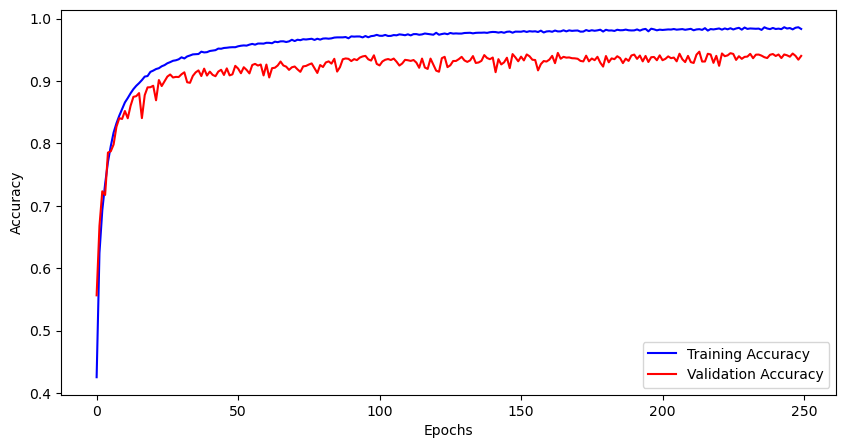

In [106]:
epochs  = [x for x in range(Epochs)]
plt.figure(figsize=(10,5))
plt.plot(epochs,training_accuracy,color="blue",label="Training Accuracy")
plt.plot(epochs,validation_accuracy,color="red",label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

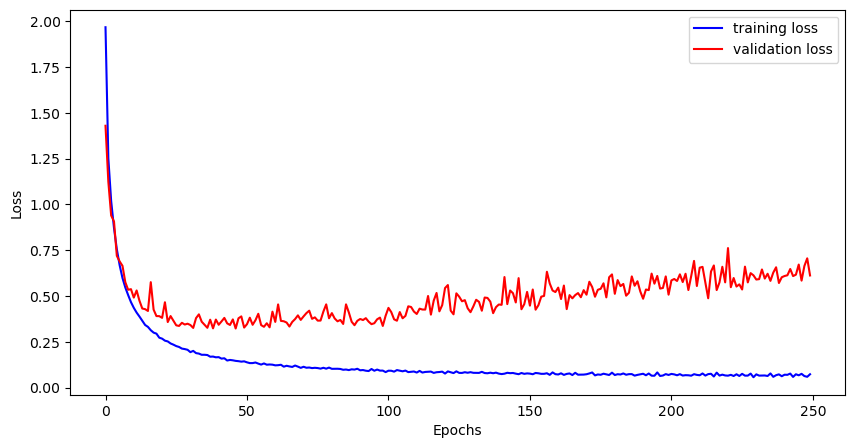

In [107]:
epochs  = [x for x in range(Epochs)]
plt.figure(figsize=(10,5))
plt.plot(epochs,loss,color="blue",label="training loss")
plt.plot(epochs,val_loss,color="red",label="validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

 ***Test Image Classification and Accuracy Calculation***

In [108]:
df_test = pd.read_csv("./germany_dataset/test.csv")
print("Number of Test Images are ", len(df_test))
df_test.head()

Number of Test Images are  12630


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


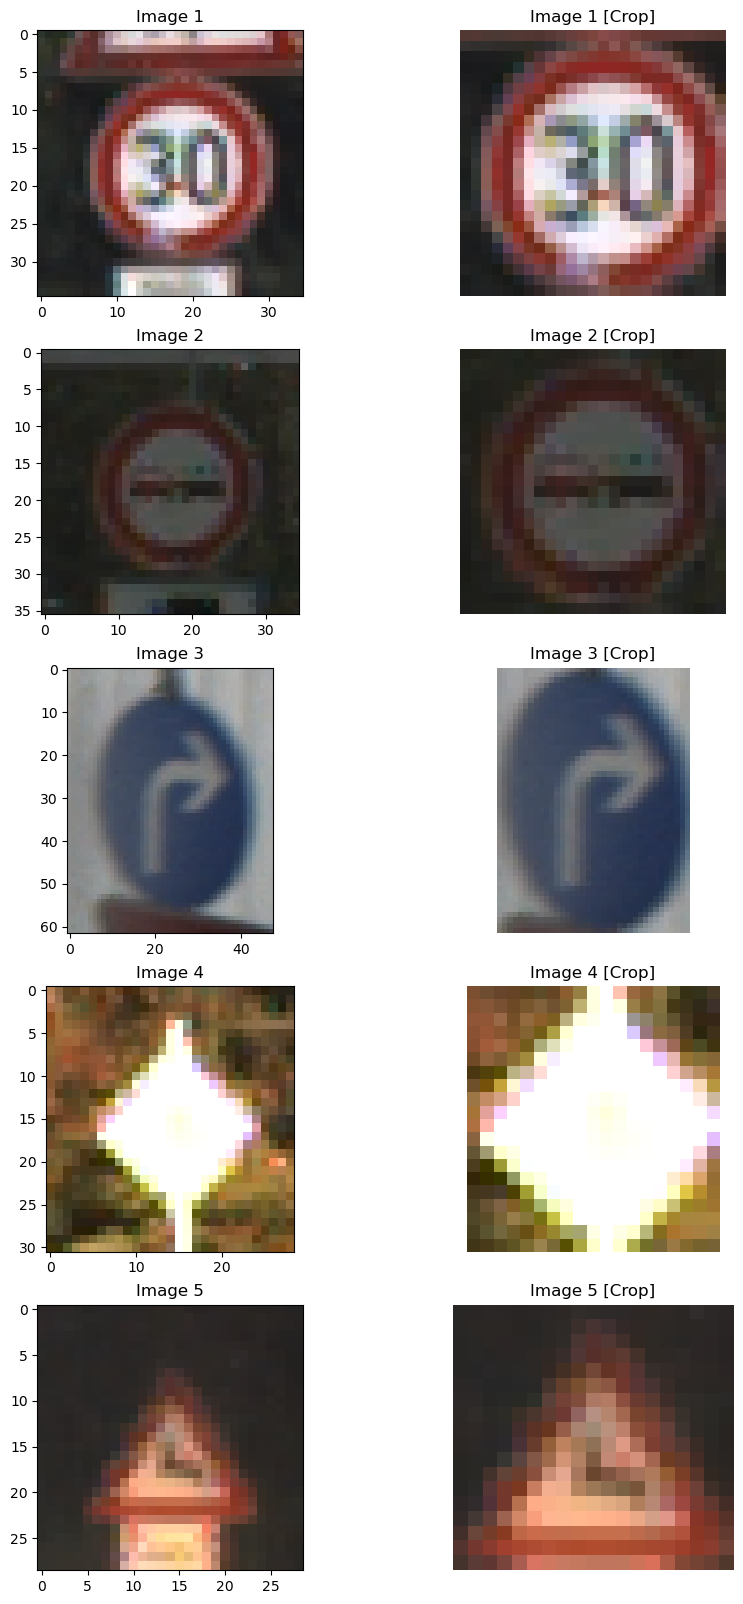

In [109]:
# Sample Images and there crop according to data given in test.csv
num_rows = 5
num_cols = 2
test_length = len(df_test.values)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
total_images = []
for i in range(5):
    integer = random.randint(0,test_length-1)
    total_images.append(df_test.iloc[integer].values)
total_images = list(total_images)
for i,val in enumerate(total_images):
    row = i
    col=0
    ax = axes[row, col]
    img = Image.open(directory+val[7])
    ax.imshow(img)
    ax.set_title(f'Image {i + 1}')
    img = img.crop((val[2],val[3],val[4],val[5]))
    ax = axes[row,col+1]
    ax.imshow(img)
    ax.set_title(f'Image {i + 1} [Crop]')
    ax.axis('off')

In [110]:
# Test Images Prediction

images = []
for row in df_test.values:
    img = Image.open(directory+row[7])
    img = img.crop((row[2],row[3],row[4],row[5]))
    img = img.resize((resize_x,resize_y))
    img = np.array(img)
    images.append(img)
y_predicted = Predict_for_Multiple_examples(model,images)

395/395 [==============================] - 1s 2ms/step


In [111]:
# Test Accuracy Determination

y_test = df_test.iloc[:,6].values
total_correct = 0;
for i in range(test_length):
    if y_predicted[i] == y_test[i]:
        total_correct=total_correct+1
accuracy = total_correct/test_length
print("Final Test Accuracy : ",accuracy*100," %")

Final Test Accuracy :  82.99287410926365  %


Original Value :  3
1/1 [==============================] - 0s 31ms/step
Predicted Value :  3


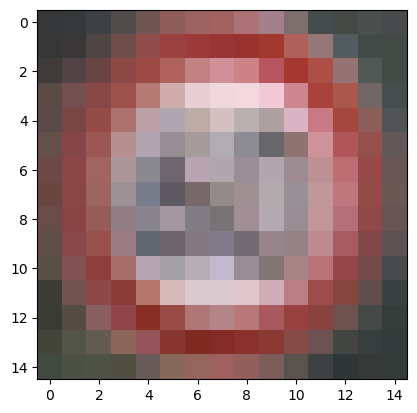

In [142]:
# Testing one Random Image from test data 

select_row=random.randint(0,test_length-1)
row = df_test.iloc[select_row]
print("Original Value : ",df_test.iloc[select_row,6])
img = Image.open(directory+row[7])
img = img.crop((row[2],row[3],row[4],row[5]))
img = img.resize((resize_x,resize_y))
plt.imshow(img)
img  = np.array(img)
img  = tf.convert_to_tensor(img,dtype=float)
img = img/255.0
img = tf.expand_dims(img, axis=0)
probability = model.predict(img)
value = get_max_index(probability[0])
print("Predicted Value : ",value)